In [1]:
# We need to import these modules to get started
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# seaborn makes pretty plots & sets font sizes nicely
import seaborn as sns
sns.set_context('notebook', font_scale=1.5, rc={'lines.markeredgewidth': 2})

# magic functions for jupyter notebook plotting
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# confirm that you are currently using the newest version of SDK (2.16.2)
import allensdk
allensdk.__version__

'2.16.2'

In [3]:
import platform
platstring = platform.platform()

if ('Darwin' in platstring) or ('macOS' in platstring):
    # macOS 
    data_root = "/Volumes/Brain2024/"
elif 'Windows'  in platstring:
    # Windows (replace with the drive letter of USB drive)
    data_root = "E:/"
elif ('amzn' in platstring):
    # then on CodeOcean
    data_root = "/data/"
else:
    # then your own linux platform
    # EDIT location where you mounted hard drive
    data_root = "/media/$USERNAME/Brain2024/"

In [4]:
# import behavior projet cache class from SDK to be able to load the data
from allensdk.brain_observatory.behavior.behavior_project_cache import VisualBehaviorOphysProjectCache

cache = VisualBehaviorOphysProjectCache.from_local_cache(cache_dir=data_root, use_static_cache=True)
# if we needed to download the data we could have used the following line
# cache = VisualBehaviorOphysProjectCache.from_s3_cache(cache_dir=data_root)  

# Get table describing ophys experiments *MOST USEFUL TABLE TO LOOK AT
ophys_experiments = cache.get_ophys_experiment_table()  

print('Number of ophys experiments = {}'.format(len(ophys_experiments)))

# get metadata tables
#behavior_sessions = cache.get_behavior_session_table()


#ophys_sessions = cache.get_ophys_session_table()


#ophys_cells = cache.get_ophys_cells_table()

#print number of items in each table for all imaging and behavioral sessions
#print('Number of behavior sessions = {}'.format(len(behavior_sessions)))
#print('Number of ophys sessions = {}'.format(len(ophys_sessions)))

import brain_observatory_utilities.datasets.optical_physiology.data_formatting as data_formatting

import brain_observatory_utilities.datasets.behavior.data_formatting as behavior_data_formatting


Number of ophys experiments = 1936


/opt/conda/lib/python3.10/site-packages/allensdk/brain_observatory/behavior/behavior_project_cache/behavior_project_cache.py:135: UpdatedStimulusPresentationTableWarning: 
	As of AllenSDK version 2.16.0, the latest Visual Behavior Ophys data has been significantly updated from previous releases. Specifically the user will need to update all processing of the stimulus_presentations tables. These tables now include multiple stimulus types delineated by the columns `stimulus_block` and `stimulus_block_name`.

The data that was available in previous releases are stored in the block name containing 'change_detection' and can be accessed in the pandas table by using: 
	`stimulus_presentations[stimulus_presentations.stimulus_block_name.str.contains('change_detection')]`
  warnings.warn(


In [5]:
# Build desired events/dff/behavior table for a single animal

def get_stacked_change_response(ophys_experiment_id):
    # Load the data for this ophys experiment from the cache
    ophys_experiment = cache.get_behavior_ophys_experiment(ophys_experiment_id)

    # Get stimulus presentations
    stimulus_presentations = ophys_experiment.stimulus_presentations.copy()
    
    
    #stimulus_presentations = behavior_data_formatting.get_annotated_stimulus_presentations(ophys_experiment, epoch_duration_mins=5)


    # Add a column for whether the previous image was novel
    stimulus_presentations['prev_image_novel'] = stimulus_presentations['is_image_novel'].shift(1)

    # Get stimulus aligned responses for all cells in this dataset
    stim_response_dff = data_formatting.get_stimulus_response_df(ophys_experiment, data_type='dff', event_type='changes',
                                                            time_window=[-1, 0.75], response_window_duration=0.25,
                                                            interpolate=True, output_sampling_rate=30)

    # Get stimulus aligned responses for all cells in this dataset
    stim_response_events = data_formatting.get_stimulus_response_df(ophys_experiment, data_type='events', event_type='changes',
                                                            time_window=[-1, 0.75], response_window_duration=0.25,
                                                            interpolate=True, output_sampling_rate=30)

    # Rename the trace columns to be specific to dff
    stim_response_dff.rename(columns={"trace": "dff_trace", "mean_response": "dff_mean_response", 
                                  "baseline_response": "dff_baseline_response"}, inplace=True)



    # Add the events trace columns to the stim_response_dff data frame
    stim_response_dff['events_trace'] = stim_response_events['trace']
    stim_response_dff['events_mean_response'] = stim_response_events['mean_response']
    stim_response_dff['events_baseline_response'] = stim_response_events['baseline_response']


    # Merge the stimulus response dataframe with the stimulus table to get information about what stimuli were presented 
    stim_response_stack = stim_response_dff.merge(stimulus_presentations, on='stimulus_presentations_id')



    stim_response_stack['ophys_experiment_id'] = ophys_experiment_id

    

    return stim_response_stack
    

In [6]:
ophys_experiments = ophys_experiments.sort_values(by=['cre_line', 'mouse_id', 'date_of_acquisition'])
#ophys_experiments[['mouse_id', 'cre_line', 'sex', 'date_of_acquisition', 'session_type', 'session_number', 'prior_exposures_to_image_set', 'prior_exposures_to_session_type']]

In [7]:
# Get only the OPHYS_4 experiments with no prior exposure to the novel image set
subset_ophys_experiments = ophys_experiments[(ophys_experiments.project_code=='VisualBehaviorMultiscope4areasx2d')&
                        (ophys_experiments.session_number==4) &
                        (ophys_experiments.prior_exposures_to_image_set==0)]

# Sort the filtered experiments by genotype, sex, mouse ID
subset_ophys_experiments = subset_ophys_experiments.sort_values(by=['cre_line', 'targeted_structure', 'sex', 'mouse_id'])


#subset_ophys_experiments[['cre_line', 'targeted_structure', 'sex', 'mouse_id', 'session_type', 'prior_exposures_to_image_set', 'prior_exposures_to_session_type']]

# there are 4 Slc17a7 animals, 4 Sst animals, and 4 Vip animals

In [8]:
# Get only the slc17a7 experiments with no prior exposure to the novel image set
slc17a7_ophys_experiments = subset_ophys_experiments[(subset_ophys_experiments.cre_line=='Slc17a7-IRES2-Cre')]

# Get only the Sst experiments
sst_ophys_experiments = subset_ophys_experiments[(subset_ophys_experiments.cre_line=='Sst-IRES-Cre')]

# Get only the Vip experiments
vip_ophys_experiments = subset_ophys_experiments[(subset_ophys_experiments.cre_line=='Vip-IRES-Cre')]


In [9]:
# CHANGE THIS TO ITERATE OVER GENOTYPES
curr_mouse_genotype = vip_ophys_experiments

# CHANGE THIS TO SAVE TO THE CORRECT FOLDER
end_folder = 'vip-cre'

# CHANGE THIS TO ITERATE OVER MICE OF A GIVEN GENOTYPE
curr_mouse_index = 3

In [10]:
curr_mouse_genotype.groupby(['mouse_id', 'ophys_experiment_id']).count().reset_index().groupby(['mouse_id']).count()[['ophys_experiment_id']]


,ophys_experiment_id
mouse_id,
489065,5
499478,7
550603,8
554115,8


In [11]:
# Get the list of mouse ids for the current genotype
mouse_id_list = curr_mouse_genotype.mouse_id.unique()
mouse_id_list

array(['489065', '499478', '550603', '554115'], dtype=object)

In [12]:
# Get the moues id for the current index
curr_mouse_id = mouse_id_list[curr_mouse_index]
curr_mouse_id

'554115'

In [13]:
# Get the list of experiment ids for the current mouse
curr_mouse_exp_list = np.array(curr_mouse_genotype[curr_mouse_genotype.mouse_id==curr_mouse_id].index)
curr_mouse_exp_list

array([1098444826, 1098444828, 1098444829, 1098444831, 1098444822,
       1098444824, 1098444819, 1098444821])

In [14]:
#  stacked_data_all = {}
# for exp_id in curr_mouse_exp_list:
#     stacked_data_all[exp_id]= get_stacked_change_response(exp_id)
    
    

In [15]:
stacked_data_df = pd.DataFrame()
for exp_id in curr_mouse_exp_list:
    curr_df = get_stacked_change_response(exp_id)
    stacked_data_df = pd.concat([stacked_data_df, curr_df], ignore_index=True)
    


/opt/conda/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
100%|██████████| 6/6 [00:00<00:00, 30.83it/s]
/opt/conda/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
100%|██████████| 14/14 [00:00<00:00, 30.52it/s]
/opt/conda/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
100%|██████████| 6/6 [00:00<00:00, 30.72it/s]
/opt/conda/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
100%|██████████| 6/6 [00:00<00:00, 30.32it/s]
/opt/conda/lib/python3

In [16]:
#stacked_data_df.columns

In [17]:
file_path = '/root/capsule/my_results/pickle_stackedcells_imagechange/' + end_folder + '/'
image_path = '/root/capsule/my_results/figures/figures_avgstackedcells_imagechange/'

In [18]:


curr_name = 'stacked_data_df_' + curr_mouse_id + '.pkl'
curr_name_svg = 'stacked_data_df_' + curr_mouse_id + '.svg'

stacked_data_df.to_pickle(file_path+curr_name,protocol=5)

In [19]:
#stacked_data_df.to_hdf(os.path.join(file_path, curr_name), key='df')

In [20]:
stacked_data_df.columns

Index(['stimulus_presentations_id', 'cell_specimen_id', 'dff_trace',
       'trace_timestamps', 'dff_mean_response', 'dff_baseline_response',
       'p_value_gray_screen', 'ophys_frame_rate', 'data_type', 'event_type',
       'interpolate', 'output_sampling_rate', 'response_window_duration',
       'events_trace', 'events_mean_response', 'events_baseline_response',
       'stimulus_block', 'stimulus_block_name', 'image_index', 'image_name',
       'movie_frame_index', 'duration', 'start_time', 'end_time',
       'start_frame', 'end_frame', 'is_change', 'is_image_novel', 'omitted',
       'movie_repeat', 'flashes_since_change', 'trials_id', 'active',
       'is_sham_change', 'stimulus_name', 'prev_image_novel',
       'ophys_experiment_id'],
      dtype='object')

In [21]:
stacked_data_df = stacked_data_df.merge(subset_ophys_experiments, left_on='ophys_experiment_id', 
                                      right_index=True, how='left')

stacked_data_df.groupby(['cre_line', 'mouse_id', 'targeted_structure', 'cell_specimen_id', 
                         'stimulus_presentations_id']).count().reset_index().groupby(['cre_line', 
                        'mouse_id','targeted_structure', 'cell_specimen_id']).count()[['stimulus_presentations_id']]


stimulus_presentations_id
cre_line     mouse_id targeted_structure cell_specimen_id                           
Vip-IRES-Cre 554115   VISal              1120124020                              172
                                         1120124129                              172
                                         1120124207                              172
                                         1120124381                              172
                                         1120124503                              172
...                                                                              ...
                      VISp               1120131291                              172
                                         1120131527                              172
                                         1120131618                              172
                                         1120131892                              172
                                         1120131911                              172

[81 rows x 1 columns]

In [22]:
stim_response_stack = stacked_data_df.copy()

stim_response_stack.sort_values(by=['cre_line', 'mouse_id', 'targeted_structure', 'cell_specimen_id'])
stim_response_stack[['cre_line', 'mouse_id', 'targeted_structure', 'cell_specimen_id', 'dff_trace', 'is_change', 'prev_image_novel', 'is_image_novel']]


,cre_line,mouse_id,targeted_structure,cell_specimen_id,dff_trace,is_change,prev_image_novel,is_image_novel
0,Vip-IRES-Cre,554115,VISal,1120124020,"[0.5014506956696538, 0.4620471426954993, 0.259...",True,True,True
1,Vip-IRES-Cre,554115,VISal,1120124129,"[-0.0033887761583623627, -0.000138327118913578...",True,True,True
2,Vip-IRES-Cre,554115,VISal,1120124207,"[0.2378824194819189, 0.23272484960812437, 0.20...",True,True,True
3,Vip-IRES-Cre,554115,VISal,1120124381,"[-0.017387545369712095, -0.01291439470654479, ...",True,True,True
4,Vip-IRES-Cre,554115,VISal,1120124503,"[0.012424365590166048, 0.015545399128777537, 0...",True,True,True
...,...,...,...,...,...,...,...,...
13927,Vip-IRES-Cre,554115,VISp,1120128668,"[-0.08065060044971183, -0.08056083807444478, -...",True,False,True
13928,Vip-IRES-Cre,554115,VISp,1120128772,"[-0.035371008068301554, -0.03634242055980429, ...",True,False,True
13929,Vip-IRES-Cre,554115,VISp,1120128849,"[0.08746030736508609, 0.08512830490138863, 0.0...",True,False,True
13930,Vip-IRES-Cre,554115,VISp,1120128991,"[-0.098361690304916, -0.0943315936988365, -0.0...",True,False,True


In [30]:
stim_response_stack.columns

Index(['stimulus_presentations_id', 'cell_specimen_id', 'dff_trace',
       'trace_timestamps', 'dff_mean_response', 'dff_baseline_response',
       'p_value_gray_screen', 'ophys_frame_rate', 'data_type', 'event_type',
       'interpolate', 'output_sampling_rate', 'response_window_duration',
       'events_trace', 'events_mean_response', 'events_baseline_response',
       'stimulus_block', 'stimulus_block_name', 'image_index', 'image_name',
       'movie_frame_index', 'duration', 'start_time', 'end_time',
       'start_frame', 'end_frame', 'is_change', 'is_image_novel', 'omitted',
       'movie_repeat', 'flashes_since_change', 'trials_id', 'active',
       'is_sham_change', 'stimulus_name', 'prev_image_novel',
       'ophys_experiment_id', 'behavior_session_id', 'ophys_session_id',
       'ophys_container_id', 'mouse_id', 'indicator', 'full_genotype',
       'driver_line', 'cre_line', 'reporter_line', 'sex', 'age_in_days',
       'imaging_depth', 'targeted_structure', 'targeted_imaging

In [23]:
# Get only the stimulus presentations with image change novel to novel
stim_response_stack_nn = stim_response_stack[(stim_response_stack.prev_image_novel==True)&
                        (stim_response_stack.is_image_novel==True)]

#novel to familiar
stim_response_stack_nf = stim_response_stack[(stim_response_stack.prev_image_novel==True) &
                                         (stim_response_stack.is_image_novel==False)]

#familiar to familiar
stim_response_stack_ff = stim_response_stack[(stim_response_stack.prev_image_novel==False) &
                                         (stim_response_stack.is_image_novel==False)]

#familiar to novel
stim_response_stack_fn = stim_response_stack[(stim_response_stack.prev_image_novel==False) &
                                         (stim_response_stack.is_image_novel==True)]

In [24]:
#[len(df.dff_trace.iloc[i] for i in range(len(df))]

In [25]:

#len(stim_response_stack_nn) + len(stim_response_stack_nf) + len(stim_response_stack_ff) + len(stim_response_stack_fn)
    

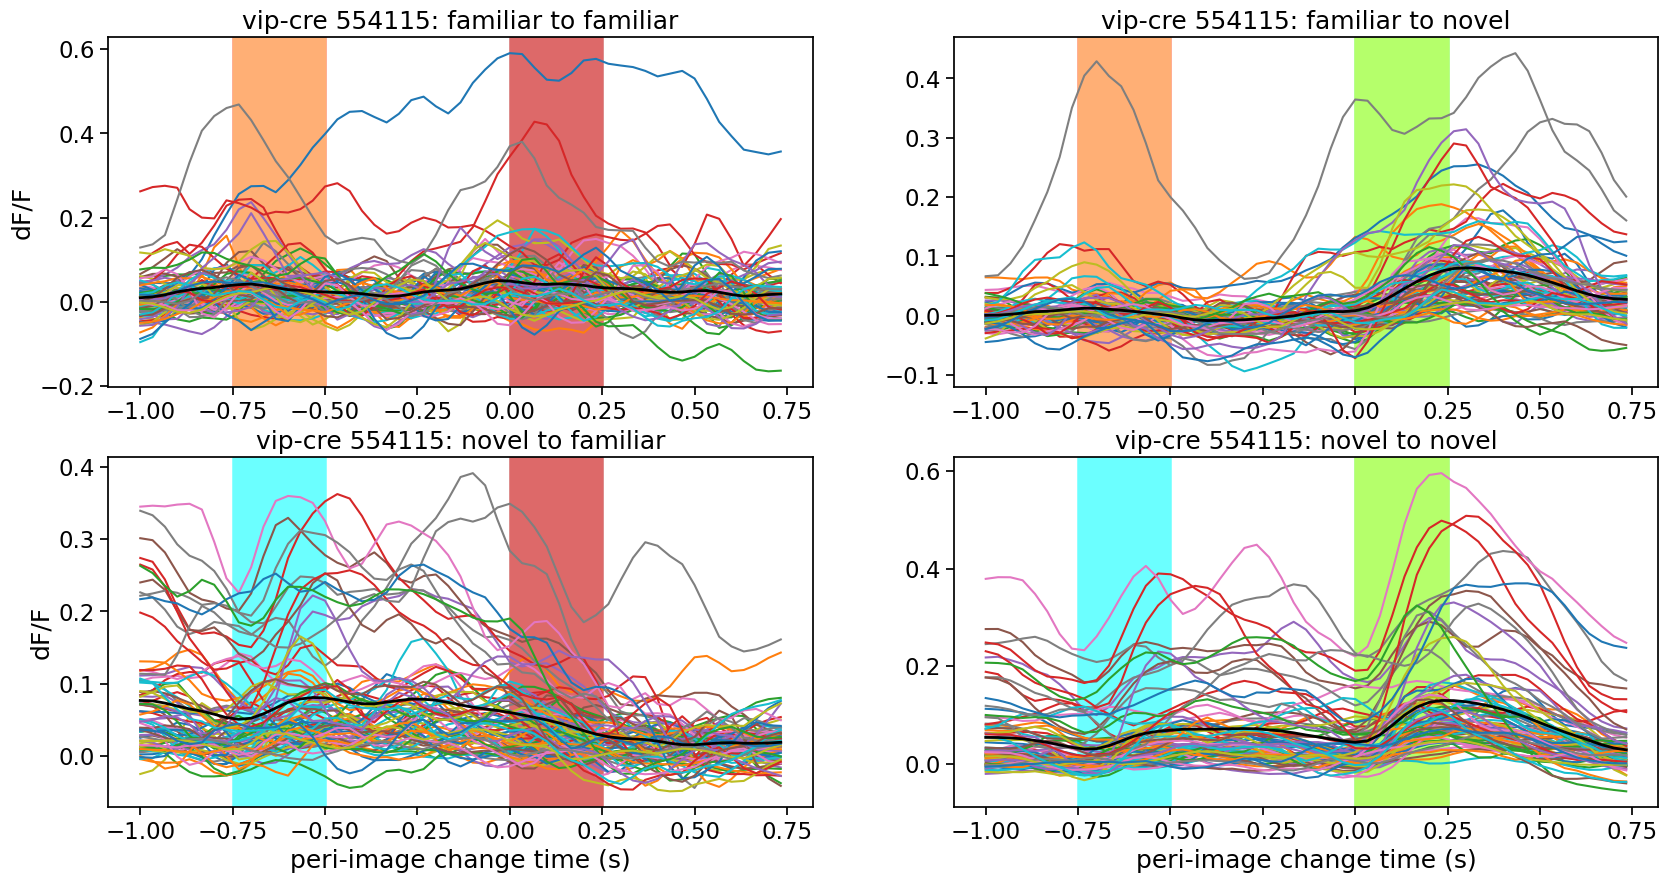

In [26]:
# Plot events for all cells: ∆F/F
fig, ax = plt.subplots(2,2,figsize=(20, 10))

# Plot familiar to familiar transitions
for cell_specimen_id in stim_response_stack_ff.cell_specimen_id.unique():
    # get the relevant data
    cell_df = stim_response_stack_ff[stim_response_stack_ff.cell_specimen_id==cell_specimen_id]
    # get the average dff trace
    mean_trace = cell_df.dff_trace.mean()
    # get the timestamps for one row ()
    timestamps = cell_df.trace_timestamps.values[0]
    ax[0, 0].plot(timestamps, mean_trace)
    ax[0, 0].axvspan(-0.75, -0.5, color='#FFAF75', alpha=0.05) # familiar image
    ax[0, 0].axvspan(0, 0.25, color='#DD6969', alpha=0.05) # different familiar image
    #ax[0, 0].set_ylim([-0.4, 0.8])
    ax[0, 0].set_ylabel('dF/F')
    ax[0, 0].set_title(str(end_folder) + ' ' + str(curr_mouse_id) + ': familiar to familiar')

mean_ff_trace = stim_response_stack_ff.dff_trace.mean()
timestamps = stim_response_stack_ff.trace_timestamps.values[0]
ax[0, 0].plot(timestamps, mean_ff_trace, color='black', linewidth=2)

    
    
# Plot familiar to novel transitions
for cell_specimen_id in stim_response_stack_fn.cell_specimen_id.unique():
    # get the relevant data
    cell_df = stim_response_stack_fn[stim_response_stack_fn.cell_specimen_id==cell_specimen_id]
    # get the average dff trace
    mean_trace = cell_df.dff_trace.mean()
    # get the timestamps for one row ()
    timestamps = cell_df.trace_timestamps.values[0]
    ax[0, 1].plot(timestamps, mean_trace)
    ax[0, 1].axvspan(-0.75, -0.5, color='#FFAF75', alpha=0.05) # familiar image
    ax[0, 1].axvspan(0, 0.25, color='#B5FF6B', alpha=0.05) # novel image
    #ax[0, 1].set_ylim([-0.4, 0.8])
    ax[0, 1].set_title(str(end_folder) + ' ' + str(curr_mouse_id) + ': familiar to novel')
    
mean_fn_trace = stim_response_stack_fn.dff_trace.mean()
timestamps = stim_response_stack_fn.trace_timestamps.values[0]
ax[0, 1].plot(timestamps, mean_fn_trace, color='black', linewidth=2)
    
    
    
# Plot novel to familiar transitions
for cell_specimen_id in stim_response_stack_nf.cell_specimen_id.unique():
    # get the relevant data
    cell_df = stim_response_stack_nf[stim_response_stack_nf.cell_specimen_id==cell_specimen_id]
    # get the average dff trace
    mean_trace = cell_df.dff_trace.mean()
    # get the timestamps for one row ()
    timestamps = cell_df.trace_timestamps.values[0]
    ax[1, 0].plot(timestamps, mean_trace)
    ax[1, 0].axvspan(-0.75, -0.5, color='#6BFFFF', alpha=0.05) # novel image
    ax[1, 0].axvspan(0, 0.25, color='#DD6969', alpha=0.05) # familiar image
    #ax[1, 0].set_ylim([-0.4, 0.8])
    ax[1, 0].set_ylabel('dF/F')
    ax[1, 0].set_xlabel('peri-image change time (s)')
    ax[1, 0].set_title(str(end_folder) + ' ' + str(curr_mouse_id) + ': novel to familiar')
    
mean_nf_trace = stim_response_stack_nf.dff_trace.mean()
timestamps = stim_response_stack_nf.trace_timestamps.values[0]
ax[1, 0].plot(timestamps, mean_nf_trace, color='black', linewidth=2)    
    
    

# Plot novel to novel transitions
for cell_specimen_id in stim_response_stack_nn.cell_specimen_id.unique():
    # get the relevant data
    cell_df = stim_response_stack_nn[stim_response_stack_nn.cell_specimen_id==cell_specimen_id]
    # get the average dff trace
    mean_trace = cell_df.dff_trace.mean()
    # get the timestamps for one row ()
    timestamps = cell_df.trace_timestamps.values[0]
    ax[1, 1].plot(timestamps, mean_trace)
    ax[1, 1].axvspan(-0.75, -0.5, color='#6BFFFF', alpha=0.05) # novel image
    ax[1, 1].axvspan(0, 0.25, color='#B5FF6B', alpha=0.05) # different novel image
    #ax[1, 1].set_ylim([-0.4, 0.8])
    ax[1, 1].set_xlabel('peri-image change time (s)')
    ax[1, 1].set_title(str(end_folder) + ' ' + str(curr_mouse_id) + ': novel to novel')
    
mean_nn_trace = stim_response_stack_nn.dff_trace.mean()
timestamps = stim_response_stack_nn.trace_timestamps.values[0]
ax[1, 1].plot(timestamps, mean_nn_trace, color='black', linewidth=2) 


    
# Save as SVG
plt.savefig(image_path+'dff_'+curr_name_svg, format="svg")

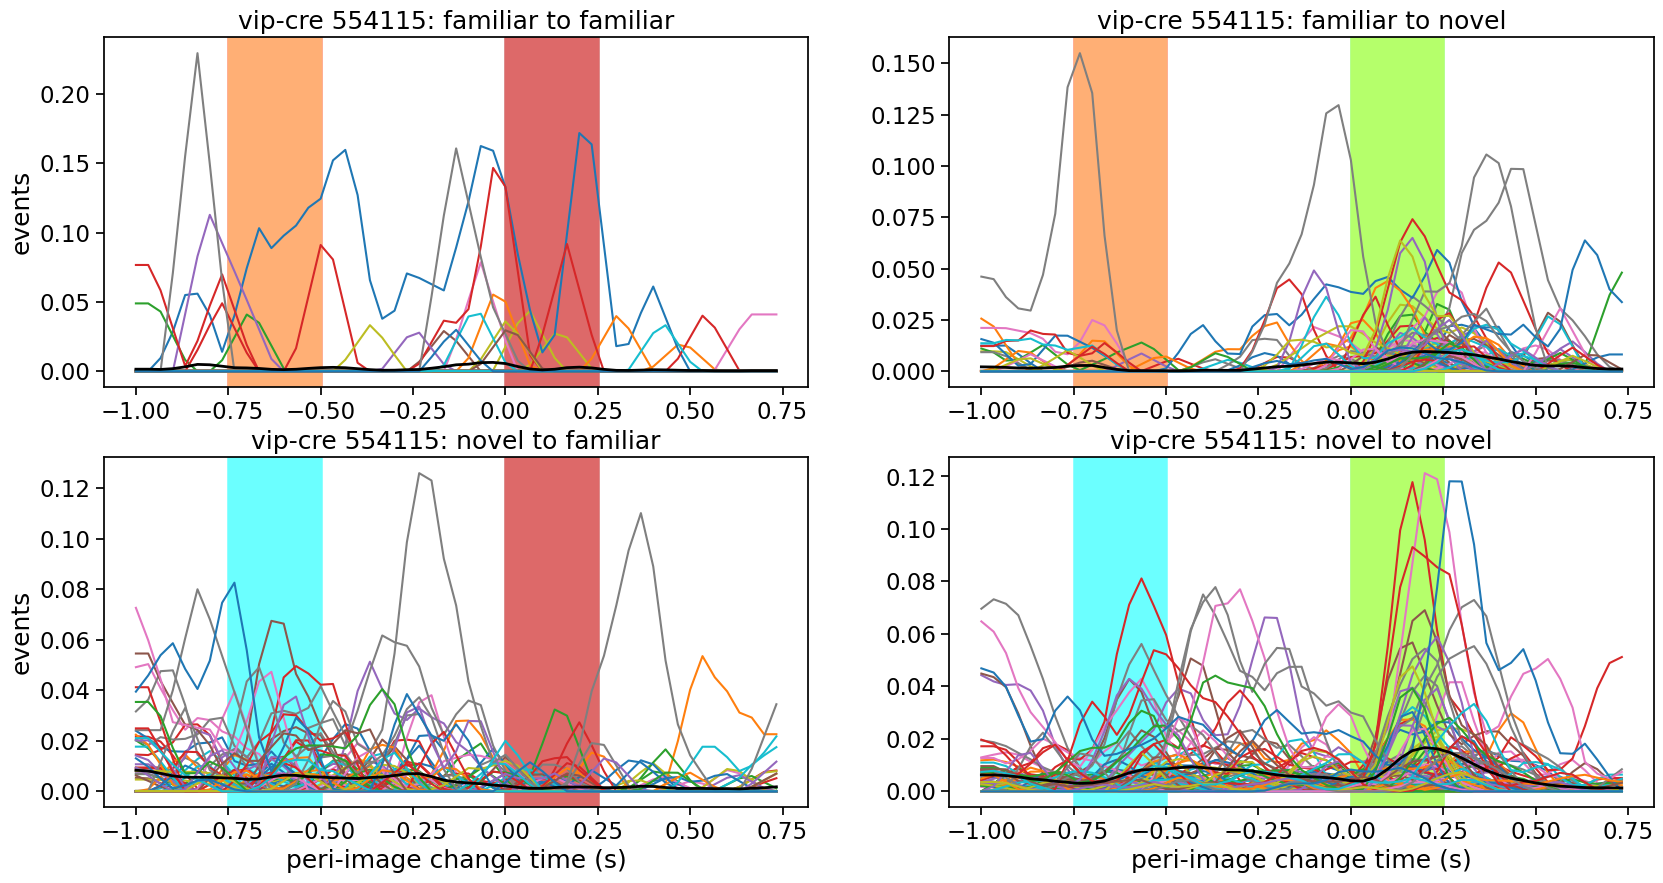

In [27]:
# Plot events for all cells: events
fig, ax = plt.subplots(2,2,figsize=(20, 10))

# Plot familiar to familiar transitions
for cell_specimen_id in stim_response_stack_ff.cell_specimen_id.unique():
    # get the relevant data
    cell_df = stim_response_stack_ff[stim_response_stack_ff.cell_specimen_id==cell_specimen_id]
    # get the average dff trace
    mean_trace = cell_df.events_trace.mean()
    # get the timestamps for one row ()
    timestamps = cell_df.trace_timestamps.values[0]
    ax[0, 0].plot(timestamps, mean_trace)
    ax[0, 0].axvspan(-0.75, -0.5, color='#FFAF75', alpha=0.05) # familiar image
    ax[0, 0].axvspan(0, 0.25, color='#DD6969', alpha=0.05) # different familiar image
    #ax[0, 0].set_ylim([-0.4, 0.8])
    ax[0, 0].set_ylabel('events')
    ax[0, 0].set_title(str(end_folder) + ' ' + str(curr_mouse_id) + ': familiar to familiar')

mean_ff_trace = stim_response_stack_ff.events_trace.mean()
timestamps = stim_response_stack_ff.trace_timestamps.values[0]
ax[0, 0].plot(timestamps, mean_ff_trace, color='black', linewidth=2)

    
    
# Plot familiar to novel transitions
for cell_specimen_id in stim_response_stack_fn.cell_specimen_id.unique():
    # get the relevant data
    cell_df = stim_response_stack_fn[stim_response_stack_fn.cell_specimen_id==cell_specimen_id]
    # get the average dff trace
    mean_trace = cell_df.events_trace.mean()
    # get the timestamps for one row ()
    timestamps = cell_df.trace_timestamps.values[0]
    ax[0, 1].plot(timestamps, mean_trace)
    ax[0, 1].axvspan(-0.75, -0.5, color='#FFAF75', alpha=0.05) # familiar image
    ax[0, 1].axvspan(0, 0.25, color='#B5FF6B', alpha=0.05) # novel image
    #ax[0, 1].set_ylim([-0.4, 0.8])
    ax[0, 1].set_title(str(end_folder) + ' ' + str(curr_mouse_id) + ': familiar to novel')
    
mean_fn_trace = stim_response_stack_fn.events_trace.mean()
timestamps = stim_response_stack_fn.trace_timestamps.values[0]
ax[0, 1].plot(timestamps, mean_fn_trace, color='black', linewidth=2)
    
    
    
# Plot novel to familiar transitions
for cell_specimen_id in stim_response_stack_nf.cell_specimen_id.unique():
    # get the relevant data
    cell_df = stim_response_stack_nf[stim_response_stack_nf.cell_specimen_id==cell_specimen_id]
    # get the average dff trace
    mean_trace = cell_df.events_trace.mean()
    # get the timestamps for one row ()
    timestamps = cell_df.trace_timestamps.values[0]
    ax[1, 0].plot(timestamps, mean_trace)
    ax[1, 0].axvspan(-0.75, -0.5, color='#6BFFFF', alpha=0.05) # novel image
    ax[1, 0].axvspan(0, 0.25, color='#DD6969', alpha=0.05) # familiar image
    #ax[1, 0].set_ylim([-0.4, 0.8])
    ax[1, 0].set_ylabel('events')
    ax[1, 0].set_xlabel('peri-image change time (s)')
    ax[1, 0].set_title(str(end_folder) + ' ' + str(curr_mouse_id) + ': novel to familiar')
    
mean_nf_trace = stim_response_stack_nf.events_trace.mean()
timestamps = stim_response_stack_nf.trace_timestamps.values[0]
ax[1, 0].plot(timestamps, mean_nf_trace, color='black', linewidth=2)    
    
    

# Plot novel to novel transitions
for cell_specimen_id in stim_response_stack_nn.cell_specimen_id.unique():
    # get the relevant data
    cell_df = stim_response_stack_nn[stim_response_stack_nn.cell_specimen_id==cell_specimen_id]
    # get the average dff trace
    mean_trace = cell_df.events_trace.mean()
    # get the timestamps for one row ()
    timestamps = cell_df.trace_timestamps.values[0]
    ax[1, 1].plot(timestamps, mean_trace)
    ax[1, 1].axvspan(-0.75, -0.5, color='#6BFFFF', alpha=0.05) # novel image
    ax[1, 1].axvspan(0, 0.25, color='#B5FF6B', alpha=0.05) # different novel image
    #ax[1, 1].set_ylim([-0.4, 0.8])
    ax[1, 1].set_xlabel('peri-image change time (s)')
    ax[1, 1].set_title(str(end_folder) + ' ' + str(curr_mouse_id) + ': novel to novel')
    
mean_nn_trace = stim_response_stack_nn.events_trace.mean()
timestamps = stim_response_stack_nn.trace_timestamps.values[0]
ax[1, 1].plot(timestamps, mean_nn_trace, color='black', linewidth=2) 
    
# Save as SVG
plt.savefig(image_path+'events_'+curr_name_svg, format="svg")

In [28]:
print('All done!')

All done!


In [29]:
stim_response_stack.cell_specimen_id.unique()

array([1120124020, 1120124129, 1120124207, 1120124381, 1120124503,
       1120124572, 1120129934, 1120130024, 1120130086, 1120130148,
       1120130216, 1120130384, 1120130519, 1120130571, 1120130661,
       1120130767, 1120130834, 1120130917, 1120130967, 1120131214,
       1120127239, 1120127465, 1120127586, 1120127668, 1120127768,
       1120128009, 1120124188, 1120124261, 1120124332, 1120124418,
       1120124570, 1120124831, 1120132882, 1120132907, 1120132921,
       1120132959, 1120132972, 1120133003, 1120133014, 1120133031,
       1120133064, 1120133086, 1120132003, 1120132099, 1120132307,
       1120132430, 1120132506, 1120128792, 1120129011, 1120129085,
       1120129186, 1120129295, 1120129410, 1120129542, 1120129658,
       1120129727, 1120129968, 1120130111, 1120130321, 1120130694,
       1120130790, 1120131005, 1120131291, 1120131527, 1120131618,
       1120131892, 1120131911, 1120127648, 1120127805, 1120127847,
       1120127936, 1120128066, 1120128224, 1120128290, 1120128

In [32]:
# Load the data for this ophys experiment from the cache
ophys_experiment = cache.get_behavior_ophys_experiment(993891831)

/opt/conda/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


In [35]:
import brain_observatory_utilities.datasets.behavior.data_formatting as behavior_data_formatting

In [38]:
# Get stimulus presentations
stimulus_presentations = ophys_experiment.stimulus_presentations
    
    
annotated_stimulus_presentations = behavior_data_formatting.get_annotated_stimulus_presentations(ophys_experiment, epoch_duration_mins=5)


/opt/conda/lib/python3.10/site-packages/brain_observatory_utilities/datasets/behavior/data_formatting.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trials['change_trials_id'] = trials.index.values


In [45]:
behavior_data_formatting.get_annotated_stimulus_presentations?

Signature:
behavior_data_formatting.get_annotated_stimulus_presentations(
    dataset,
    epoch_duration_mins=10,
)
Docstring:
Takes in an SDK dataset object and returns the stimulus_presentations table with additional columns.
Adds several useful columns to the stimulus_presentations table, including the mean running speed and pupil diameter for each stimulus,
the times of licks for each stimulus, the rolling reward rate, an identifier for 10 minute epochs within a session,
whether or not a stimulus was a pre-change or pre or post omission, and whether change stimuli were hits or misses
:param dataset: obj
    AllenSDK BehaviorOphysExperiment object
    or AllenSDK BehaviorEcephysSession object
    or AllenSDK BehaviorSession object
    See:
    https://github.com/AllenInstitute/AllenSDK/blob/master/allensdk/brain_observatory/behavior/behavior_ophys_experiment.py  # noqa E501
    https://github.com/AllenInstitute/AllenSDK/blob/master/allensdk/brain_observatory/ecephys/behavior_ecephy

In [42]:

stimulus_presentations[(stimulus_presentations.stimulus_block_name=='change_detection_behavior') & 
                       (stimulus_presentations.is_change==True)]

,stimulus_block,stimulus_block_name,image_index,image_name,movie_frame_index,duration,start_time,end_time,start_frame,end_frame,is_change,is_image_novel,omitted,movie_repeat,flashes_since_change,trials_id,active,is_sham_change,stimulus_name
stimulus_presentations_id,,,,,,,,,,,,,,,,,,,
26,1,change_detection_behavior,2,im083_r,-99,0.25016,327.746971,327.997131,19111,19126,True,False,False,-99,0,7,True,False,Natural_Images_Lum_Matched_set_ophys_H_2019
36,1,change_detection_behavior,5,im024_r,-99,0.25022,335.253071,335.503291,19561,19576,True,True,False,-99,0,8,True,False,Natural_Images_Lum_Matched_set_ophys_H_2019
63,1,change_detection_behavior,2,im083_r,-99,0.25021,355.519621,355.769831,20776,20791,True,False,False,-99,0,15,True,False,Natural_Images_Lum_Matched_set_ophys_H_2019
76,1,change_detection_behavior,3,im005_r,-99,0.25021,365.277621,365.527831,21361,21376,True,True,False,-99,0,16,True,False,Natural_Images_Lum_Matched_set_ophys_H_2019
93,1,change_detection_behavior,6,im111_r,-99,0.25020,378.054731,378.304931,22127,22142,True,False,False,-99,0,18,True,False,Natural_Images_Lum_Matched_set_ophys_H_2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4680,1,change_detection_behavior,4,im087_r,-99,0.25019,3821.650821,3821.901011,228574,228589,True,True,False,-99,0,836,True,False,Natural_Images_Lum_Matched_set_ophys_H_2019
4715,1,change_detection_behavior,5,im024_r,-99,0.25020,3847.922311,3848.172511,230145,230160,True,True,False,-99,0,849,True,False,Natural_Images_Lum_Matched_set_ophys_H_2019
4749,1,change_detection_behavior,3,im005_r,-99,0.25019,3873.443141,3873.693331,231675,231690,True,True,False,-99,0,855,True,False,Natural_Images_Lum_Matched_set_ophys_H_2019


In [43]:
annotated_stimulus_presentations[(annotated_stimulus_presentations.stimulus_block_name=='change_detection_behavior') & 
                       (annotated_stimulus_presentations.is_change==True)]

,trials_id,stimulus_block,stimulus_block_name,image_index,image_name,movie_frame_index,duration,start_time,end_time,start_frame,...,previous_change_on_trial,could_change,pre_change,lick_on_next_flash,pre_omitted,post_omitted,reward_rate,engaged,engagement_state,epoch
stimulus_presentations_id,,,,,,,,,,,,,,,,,,,,,
26,7,1,change_detection_behavior,2,im083_r,-99,0.25016,327.746971,327.997131,19111,...,False,True,False,False,False,False,inf,True,engaged,0
36,8,1,change_detection_behavior,5,im024_r,-99,0.25022,335.253071,335.503291,19561,...,False,True,False,True,False,False,2.745148,True,engaged,0
63,15,1,change_detection_behavior,2,im083_r,-99,0.25021,355.519621,355.769831,20776,...,False,True,False,True,False,False,2.916613,True,engaged,0
76,16,1,change_detection_behavior,3,im005_r,-99,0.25021,365.277621,365.527831,21361,...,False,True,False,True,False,False,3.207364,True,engaged,0
93,18,1,change_detection_behavior,6,im111_r,-99,0.25020,378.054731,378.304931,22127,...,False,True,False,True,False,False,3.319262,True,engaged,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4680,836,1,change_detection_behavior,4,im087_r,-99,0.25019,3821.650821,3821.901011,228574,...,False,True,False,True,False,False,1.125664,False,disengaged,11
4715,849,1,change_detection_behavior,5,im024_r,-99,0.25020,3847.922311,3848.172511,230145,...,False,True,False,False,False,False,1.133825,False,disengaged,11
4749,855,1,change_detection_behavior,3,im005_r,-99,0.25019,3873.443141,3873.693331,231675,...,False,True,False,False,False,False,1.366404,False,disengaged,11


In [44]:
annotated_stimulus_presentations.columns

Index(['trials_id', 'stimulus_block', 'stimulus_block_name', 'image_index',
       'image_name', 'movie_frame_index', 'duration', 'start_time', 'end_time',
       'start_frame', 'end_frame', 'is_change', 'is_image_novel', 'omitted',
       'movie_repeat', 'flashes_since_change', 'active', 'is_sham_change',
       'stimulus_name', 'licks', 'mean_running_speed', 'mean_pupil_width',
       'change_trials_id', 'change_time', 'go', 'catch', 'auto_rewarded',
       'hit', 'miss', 'false_alarm', 'correct_reject', 'response_time',
       'reward_time', 'reward_volume', 'response_latency',
       'time_from_last_change', 'licked', 'stimulus_count_within_trial',
       'previous_image_name', 'previous_response_on_trial',
       'previous_change_on_trial', 'could_change', 'pre_change',
       'lick_on_next_flash', 'pre_omitted', 'post_omitted', 'reward_rate',
       'engaged', 'engagement_state', 'epoch'],
      dtype='object')